In [3]:
import tensorflow as tf
import keras
tf.enable_eager_execution ()
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras import layers
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from IPython.display import clear_output
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession



In [4]:
spark

In [5]:
def load_data():
#Load data from Hive tables, see feature extraction ETL for more details#
    START_DATEINT = 20191206
    COUNTRY = 'BR'

    load_data_query = '''
        SELECT title_id, 
            season_title_id, 
            show_title_id, 
            is_season_finale, 
            is_kids,is_original, 
            site_country_iso_code, 
            bytes_steered, 
            steering_site_name, 
            cluster_index,
            days_since_launch_date, 
            genre, 
            mylist_add_7d, 
            coalesce(round(imdb_user_rating_avg, 2), 0) as imdb_user_rating_avg, 
            coalesce(imdb_user_rating_cnt, 0) as imdb_user_rating_cnt ,
            coalesce(imdb_user_review_cnt, 0) as imdb_user_review_cnt , 
            coalesce(imdb_critic_review_cnt, 0) as imdb_critic_review_cnt , 
            case when title_type = 'SERIES CHILD' then 0 else 1 end title_type, 
            original_language, runtime_minutes, playtime_minutes_steered
        from ldeek.clustering_title_pred_features f
        where country_dateint = %i
        and country_iso_code =  \'%s\'
        '''

    load_data_query = (load_data_query) % (START_DATEINT,
                                           COUNTRY)
    features_data = spark.sql(load_data_query)

    #Convert the dataframe to Pandas
    all_data = features_data.select("*").toPandas()
    
    return all_data

In [6]:
#Prepare data for the model
#Convert all boolean columns to int
def bool_to_int(dataset, column_arr):
    dataset[column_arr] = dataset[column_arr].astype('int')
    return dataset

#one-hot encoder categorical features
def one_hot_encoder(dataset, feature):
    featureBinarizer = LabelBinarizer().fit(dataset[feature])
    feature_encoded = featureBinarizer.transform(dataset[feature])
    return feature_encoded

#Embedding for show, season and title ids
def feature_embed(dataset, feature):
    embedding_layer = layers.Embedding(81217800, 10)
    feature_embedding = embedding_layer(tf.constant(dataset[feature]))
    return feature_embedding

def normalize_data(dataset):
    # create scaler
    scaler = MinMaxScaler()
    # fit scaler on data
    scaler.fit(dataset)
    # apply transform
    normalized = scaler.transform(dataset)
    return normalized


In [7]:
def analyze_correlation(dataset):
    #Analyze the data correlation
    C_mat = dataset.corr()
    fig = plt.figure(figsize = (15,15))

    sb.heatmap(C_mat, vmax = .8, square = True)
    plt.savefig('./feature_correlation.png')
    plt.show()

In [8]:
def define_NN_model(data):
    #turn off the eager execution in tensorflow
    INPUT_LAYER = 105
    HIDDEN_LAYER1 = 80
    HIDDEN_LAYER2 = 80
    HIDDEN_LAYER3 = 80
    OUTPUT_LAYER = 1
    
    ACIVATION_FUNC = 'relu'
    OPTIMIZER = 'adam'
    METRIC = 'mean_absolute_error'
    
    tf.compat.v1.disable_eager_execution()

    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(INPUT_LAYER, kernel_initializer='normal',input_dim = data.shape[1], activation=ACIVATION_FUNC))

    # The Hidden Layers :
    NN_model.add(Dense(HIDDEN_LAYER1, kernel_initializer='normal',activation=ACIVATION_FUNC))
    NN_model.add(Dense(HIDDEN_LAYER2, kernel_initializer='normal',activation=ACIVATION_FUNC))
    NN_model.add(Dense(HIDDEN_LAYER3, kernel_initializer='normal',activation=ACIVATION_FUNC))
 #   NN_model.add(Dense(HIDDEN_LAYER4, kernel_initializer='normal',activation=ACIVATION_FUNC))


    # The Output Layer :
    NN_model.add(Dense(OUTPUT_LAYER, kernel_initializer='normal',activation=ACIVATION_FUNC))

    # Compile the network :
    NN_model.compile(loss=METRIC, optimizer=OPTIMIZER, metrics=[METRIC])
    NN_model.summary()
    return NN_model

In [9]:
def plot_predictions(orig_data, pred_data):
    #plot predictions and expected y labels
    p = pred_data[:10000]
    y = orig_data[:10000]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    orig, = ax.plot(range(y.shape[0]),y,'bs')
    pred, = ax.plot(range(y.shape[0]),p, 'g^')
    leg2 = ax.legend([orig,pred],['original data','prediction data'], loc='best')
    plt.ylabel('log Streaming')
    plt.xlabel('Titles Site pair')
    plt.title('Title Predictions')

In [10]:
def main(plot=True):
    # Seed the randomness of the simulation so this outputs the same thing each time
    np.random.seed(0)
    
    EPOCHS = 100
    BATCH_SIZE = 1000
    VALIDATIION_SPLIT = 0.1
    
    #load all data for modeling
    all_data = load_data()
    
    #if plot:
    # plot the correlation between features
    analyze_correlation(all_data)

    #The prediction for playtime minutes steered, consider log for normal distribution
    target = np.log(all_data.playtime_minutes_steered.replace(0,1))
    
    #Prepare data for the model
    #Convert all boolean columns to int
    bool_cols = ['is_season_finale', 'is_kids', 'is_original']
    bool_to_int(all_data, bool_cols)
    
    #Identify continuous features
    continuous = ['is_season_finale', 'runtime_minutes','is_kids', 'cluster_index',
              'is_original','days_since_launch_date', 'mylist_add_7d', 
              'imdb_user_rating_avg', 'imdb_user_rating_cnt',
             'imdb_user_review_cnt', 'imdb_critic_review_cnt',
              'title_type']

    dataContinuous = all_data[continuous]
    
    # one-hot encode the genre categorical data 
    genre_onehot = one_hot_encoder(all_data, 'genre')
    # one-hot encode the language categorical data 
    lang_onehot = one_hot_encoder(all_data,'original_language')
    # one-hot encode the country categorical data 
    cntry_onehot = one_hot_encoder(all_data,'site_country_iso_code')
    
    #Embedding for show, season and title ids
    show_title_emb = feature_embed(all_data, 'show_title_id')
    season_title_emb = feature_embed(all_data, 'season_title_id')
    title_emb = feature_embed(all_data, 'title_id')
    
    # Combining all of above transformed data
    dataX = np.hstack([dataContinuous, genre_onehot, lang_onehot, cntry_onehot, show_title_emb, season_title_emb, title_emb])

    #Normalize data
    normalized_features = normalize_data(dataX)
    
    # Split into train and test dataset for 70:30
    train_X, test_X, train_y, test_y = train_test_split(normalized_features, target, test_size = 0.30, random_state = 10)
    
    # Create checkpoint for model training
    checkpoint_name = 'Weights.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    callbacks_list = [checkpoint]
    
    NN_model = define_NN_model(train_X)
    
    NN_model.summary()
    
    #Train the model NN_model

    NN_model.fit(train_X, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATIION_SPLIT,
             callbacks=[plot_losses])

    #Make predictions on test data
    predictions = NN_model.predict(test_X)
    print(predictions.shape)
    #if plot:
    # plot the correlation between features
    plot_predictions(test_y, predictions)

    return predictions

In [11]:
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.accuracy = []
        self.val_losses = []
        self.val_accuracy = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        print(self.logs)
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            print(self.val_losses)
            print(self.losses)
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            #plt.figure()
            plt.figure(figsize=(15,5))
            plt.plot(N, self.losses, label = "train_loss")
            #plt.plot(N, self.accuracy, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            #plt.plot(N, self.val_accuracy, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()
            plt.savefig('./NN_model_losses_plot.png')

plot_losses = TrainingPlot()

[2.175138534352745, 2.1606174976017365, 2.1385529228975364, 2.1206399244816807, 2.1261722145504725, 2.115209853688079, 2.125855871543036, 2.1084523266131683, 2.106586275018636, 2.1122793689443453, 2.108370747282487, 2.1102344495054717, 2.103104016275188, 2.105776449594913, 2.1071960725849426, 2.1040616552908404, 2.1022544727447063, 2.100251695428775, 2.1078832781080754, 2.1030927497476353, 2.1004209358974446, 2.1033484526026043, 2.0998713852897355, 2.1046733908693045, 2.0999329930494266, 2.0979510091290616, 2.1008359408441177, 2.099497096286114, 2.097647227184856, 2.0977412898983245, 2.0966838982543003, 2.0972607928051827, 2.096745860370327, 2.0970707262749464, 2.0979268027019673, 2.096758131536835, 2.095919195379429, 2.0966913925409965, 2.099545002444974, 2.0954094679023783, 2.0966277119253376, 2.096329232485093, 2.097125726958271, 2.0952498600443383, 2.0968421772294414, 2.096812859036032, 2.0956204728671333, 2.096125843757594, 2.0977552887319657, 2.095265313121307, 2.095373875577972,

<Figure size 576x396 with 0 Axes>

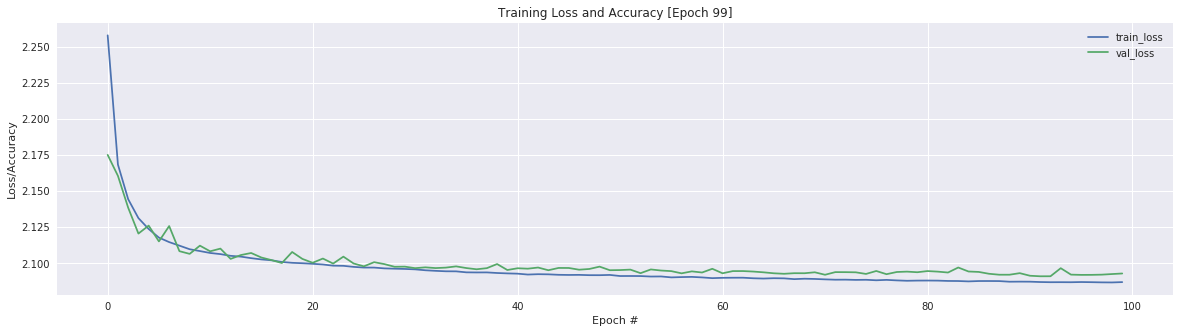

(3231510, 1)


<Figure size 576x396 with 0 Axes>

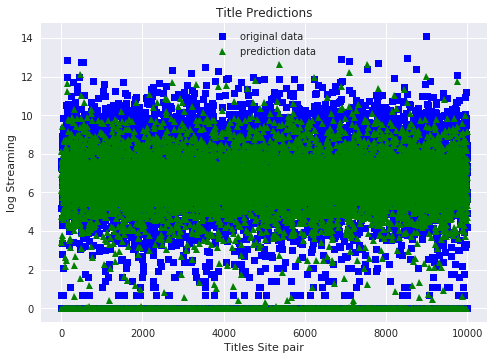

In [12]:
if __name__ == '__main__':
    main()